In [15]:
import numpy as np
import sys 
import os
import matplotlib.pyplot as plt
#from utils import *
import copy
#import models
import cv2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
#import skimage.io as io
#import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import keras.backend.tensorflow_backend as K

In [16]:
img_width = 64
img_height = 64
img_depth = 16

label_dir_pre = '/storage/filament/result/label/'
img_dir_pre = '/storage/filament/result/cluster_3d/40Mpc/density_smooting_plot_5/'

box_num = 'box01/'

tmp_img = []
tmp_label = []
os.listdir(label_dir_pre + box_num)

for sub_num in os.listdir(label_dir_pre + box_num):
    peak_list = os.listdir(label_dir_pre + box_num + sub_num + '/')
    for peak_num in peak_list:
        label_dir = label_dir_pre + box_num + sub_num + '/' + peak_num + '/whole/'
        img_dir = img_dir_pre + box_num + sub_num + '/' + peak_num + '/'

        os.chdir(label_dir)
        for nn,_ in enumerate(os.listdir(label_dir)):
            #tmp_label.append(cv2.imread(str(nn) + '.png',cv2.IMREAD_GRAYSCALE))
            tmp_label.append (cv2.resize(cv2.imread(str(nn) + '.png',cv2.IMREAD_GRAYSCALE),(img_width,img_height)))
            
        os.chdir(img_dir)
        for nn,_ in enumerate(os.listdir(img_dir)):
            #tmp_img.append(cv2.imread(str(nn) + '.png',cv2.IMREAD_GRAYSCALE))
            tmp_img.append(cv2.resize(cv2.imread(str(nn) + '.png',cv2.IMREAD_GRAYSCALE),(img_width,img_height)))
#            img_file[nn,:,:] = cv2.imread(str(nn) + '.png',cv2.IMREAD_GRAYSCALE)


In [10]:
label_file = np.array(tmp_label)/255.
img_file = np.array(tmp_img)

file_num = int(label_file.shape[0]/img_depth)


In [11]:
label_file = label_file.reshape([file_num,img_depth,img_height,img_width])
img_file = img_file.reshape([file_num,img_depth,img_height,img_width])

In [12]:
img_train = np.expand_dims(img_file,axis=-1)
label_train = np.expand_dims(label_file,axis=-1)

print(img_train.shape,label_train.shape)

(18, 16, 64, 64, 1) (18, 16, 64, 64, 1)


In [14]:
model = get_unet()
with K.tf.device('/gpu:0'):
    hist = model.fit(img_train, label_train, batch_size=3, epochs=100)

#model.summary()

Epoch 1/10
18/18 [==============================] - 13s 707ms/step - loss: -0.1282 - dice_coef: 0.1282
Epoch 2/10
18/18 [==============================] - 8s 452ms/step - loss: -0.1529 - dice_coef: 0.1529
Epoch 3/10
18/18 [==============================] - 8s 455ms/step - loss: -0.1674 - dice_coef: 0.1674
Epoch 4/10
18/18 [==============================] - 8s 455ms/step - loss: -0.1798 - dice_coef: 0.1798
Epoch 5/10
18/18 [==============================] - 8s 453ms/step - loss: -0.1919 - dice_coef: 0.1919
Epoch 6/10
18/18 [==============================] - 8s 453ms/step - loss: -0.2021 - dice_coef: 0.2021
Epoch 7/10
18/18 [==============================] - 8s 453ms/step - loss: -0.2098 - dice_coef: 0.2098
Epoch 8/10
18/18 [==============================] - 8s 455ms/step - loss: -0.2284 - dice_coef: 0.2284
Epoch 9/10
18/18 [==============================] - 8s 450ms/step - loss: -0.2369 - dice_coef: 0.2369
Epoch 10/10
18/18 [==============================] - 8s 452ms/step - loss: -0.249

In [6]:
def get_unet_3d():
    
    n = 2
    #inputs = Input((img_width,img_height,depth,1))
    inputs = Input((img_depth,img_width,img_height,1))

    #inputs = Input((None, None,  None, 1))
    conv1 = Conv3D(n, (2, 2, 2), padding='same')(inputs)
    conv1 = BatchNormalization(axis=4)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv3D(n, (2, 2, 2), padding='same')(conv1)
    conv1 = BatchNormalization(axis=4)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv3D(n, (2, 2, 2), padding='same')(conv1)
    conv1 = BatchNormalization(axis=4)(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = Conv3D(n, (2, 2, 2), padding='same', strides = (2 ,2, 2))(conv1)
    pool1 = BatchNormalization(axis=4)(pool1)
    pool1 = Activation('relu')(pool1)
#    pool1 = Dropout(0.25)(pool1)
#    pool1 = MaxPooling3D(pool_size=(2, 2, 1))(conv1)

    conv22 = concatenate([pool1, MaxPooling3D(pool_size=(2, 2, 2))(inputs)], axis=4)
    conv2 = Conv3D(2*n, (2, 2, 2), padding='same')(conv22)
    conv2 = BatchNormalization(axis=4)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv3D(2*n, (2, 2, 2), padding='same')(conv2)
    conv2 = BatchNormalization(axis=4)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv3D(2*n, (2, 2, 2), padding='same')(conv2)
    conv2 = BatchNormalization(axis=4)(conv2)
    conv2 = Activation('relu')(conv2)                           
    pool2 = Conv3D(2*n, (2, 2, 2), padding='same', strides = (2, 2, 2))(conv2)
    pool2 = BatchNormalization(axis=4)(pool2)
    pool2 = Activation('relu')(pool2)
#    pool2 = Dropout(0.25)(pool2)
#    pool2 = MaxPooling3D(pool_size=(2, 2, 1))(conv2)

    conv33 = concatenate([pool2, MaxPooling3D(pool_size=(2, 2, 2))(conv22)], axis=4)
    conv3 = Conv3D(4*n, (2, 2, 2), padding='same')(conv33)    
    conv3 = BatchNormalization(axis=4)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv3D(4*n, (2, 2, 2), padding='same')(conv3)    
    conv3 = BatchNormalization(axis=4)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv3D(4*n, (2, 2, 2), padding='same')(conv3)
    conv3 = BatchNormalization(axis=4)(conv3)
    conv3 = Activation('relu')(conv3)
#    conv3 = Conv3D(4*n, (3, 3, 3), padding='same')(conv3)
#    conv3 = BatchNormalization(axis=4)(conv3)
#    conv3 = Activation('relu')(conv3)
    pool3 = Conv3D(2*n, (2, 2, 2), padding='same', strides = (2, 2, 2))(conv3)
    pool3 = BatchNormalization(axis=4)(pool3)
    pool3 = Activation('relu')(pool3)
    
    
    conv44 = concatenate([pool3, MaxPooling3D(pool_size=(2, 2, 2))(conv33)], axis=4)
    conv4 = Conv3D(8*n, (2, 2, 2), padding='same')(conv44)    
    conv4 = BatchNormalization(axis=4)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv3D(8*n, (2, 2, 2), padding='same')(conv4)    
    conv4 = BatchNormalization(axis=4)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv3D(8*n, (2, 2, 2), padding='same')(concatenate([conv44, conv4], axis=4))
    conv4 = BatchNormalization(axis=4)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv3D(8*n, (2, 2, 2), padding='same')(conv4)    
    conv4 = BatchNormalization(axis=4)(conv4)
    conv4 = Activation('relu')(conv4)
#    conv3 = Dropout(0.5)(conv3)
#    pool3 = MaxPooling3D(pool_size=(2, 2, 1))(conv3)

#    conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool3)
#    conv4 = BatchNormalization(axis=1)(conv4)
#    conv4 = Activation('relu')(conv4)
#    conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv4)
#    conv4 = BatchNormalization(axis=1)(conv4)

    up5 = concatenate([Conv3DTranspose(2*n, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv4), conv3], axis=4)
    conv5 = Conv3D(4*n, (2, 2, 2), padding='same')(up5)
    conv5 = BatchNormalization(axis=4)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv3D(4*n, (2, 2, 2), padding='same')(conv5)
    conv5 = BatchNormalization(axis=4)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv3D(4*n, (2, 2, 2), padding='same')(concatenate([up5, conv5], axis=4))
    conv5 = BatchNormalization(axis=4)(conv5)
    conv5 = Activation('relu')(conv5)
    
    up6 = concatenate([Conv3DTranspose(n, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5), conv2], axis=4)
    conv6 = Conv3D(2*n, (2, 2, 2), padding='same')(up6)
    conv6 = BatchNormalization(axis=4)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv3D(2*n, (2, 2, 2), padding='same')(conv6)
    conv6 = BatchNormalization(axis=4)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv3D(2*n, (2, 2, 2), padding='same')(concatenate([up6, conv6], axis=4))
    conv6 = BatchNormalization(axis=4)(conv6)
    conv6 = Activation('relu')(conv6)

    up7 = concatenate([Conv3DTranspose(n, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6), conv1], axis=4)
    conv7 = Conv3D(n, (2, 2, 2), padding='same')(up7)
    conv7 = BatchNormalization(axis=4)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv3D(n, (2, 2, 2), padding='same')(conv7)
    conv7 = BatchNormalization(axis=4)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv3D(n, (2, 2, 2), padding='same')(concatenate([up7, conv7], axis=4))
    conv7 = BatchNormalization(axis=4)(conv7)
    conv7 = Activation('relu')(conv7)
 #   up6 = concatenate([Conv3DTranspose(16, (2, 2, 1), strides=(2, 2, 1), padding='same')(conv5), conv1], axis=4)
 #   conv6 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(up6)
 #   conv6 = BatchNormalization(axis=1)(conv6)
 #   conv6 = Activation('relu')(conv6)
 #   conv6 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv6)
 #   conv6 = BatchNormalization(axis=1)(conv6)
 #   conv6 = Activation('relu')(conv6)
    
    conv8 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv7)
    
    model = Model(inputs=[inputs], outputs=[conv8])
    
    learning_rate = 1e-3
    decay_rate = learning_rate/300
    
    model.compile(optimizer=Adam(lr=learning_rate, decay=decay_rate), loss=dice_coef_loss, metrics=[dice_coef])
#   model.compile(optimizer=Adam(lr=1e-5), loss=losses.mean_squared_error, metrics=[dice_coef])

    return model

# In[ ]:


## loss function
smooth = 1e-7

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth * 0.01) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [13]:
## model 3D Unet
def get_unet():
    
    n = 8
    
    inputs = Input((None, None,  None, 1))
    conv1 = Conv3D(n, (3, 3, 3), padding='same')(inputs)
    conv1 = BatchNormalization(axis=4)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv3D(n, (3, 3, 3), padding='same')(conv1)
    conv1 = BatchNormalization(axis=4)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv3D(n, (3, 3, 3), padding='same')(conv1)
    conv1 = BatchNormalization(axis=4)(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = Conv3D(n, (3, 3, 3), padding='same', strides = (2 ,2, 2))(conv1)
    pool1 = BatchNormalization(axis=4)(pool1)
    pool1 = Activation('relu')(pool1)
#    pool1 = Dropout(0.25)(pool1)
#    pool1 = MaxPooling3D(pool_size=(2, 2, 1))(conv1)

    conv22 = concatenate([pool1, MaxPooling3D(pool_size=(2, 2, 2))(inputs)], axis=4)
    conv2 = Conv3D(2*n, (3, 3, 3), padding='same')(conv22)
    conv2 = BatchNormalization(axis=4)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv3D(2*n, (3, 3, 3), padding='same')(conv2)
    conv2 = BatchNormalization(axis=4)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv3D(2*n, (3, 3, 3), padding='same')(conv2)
    conv2 = BatchNormalization(axis=4)(conv2)
    conv2 = Activation('relu')(conv2)                           
    pool2 = Conv3D(2*n, (3, 3, 3), padding='same', strides = (2, 2, 2))(conv2)
    pool2 = BatchNormalization(axis=4)(pool2)
    pool2 = Activation('relu')(pool2)
#    pool2 = Dropout(0.25)(pool2)
#    pool2 = MaxPooling3D(pool_size=(2, 2, 1))(conv2)

    conv33 = concatenate([pool2, MaxPooling3D(pool_size=(2, 2, 2))(conv22)], axis=4)
    conv3 = Conv3D(4*n, (3, 3, 3), padding='same')(conv33)    
    conv3 = BatchNormalization(axis=4)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv3D(4*n, (3, 3, 3), padding='same')(conv3)    
    conv3 = BatchNormalization(axis=4)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv3D(4*n, (3, 3, 3), padding='same')(conv3)
    conv3 = BatchNormalization(axis=4)(conv3)
    conv3 = Activation('relu')(conv3)
#    conv3 = Conv3D(4*n, (3, 3, 3), padding='same')(conv3)
#    conv3 = BatchNormalization(axis=4)(conv3)
#    conv3 = Activation('relu')(conv3)
    pool3 = Conv3D(2*n, (3, 3, 3), padding='same', strides = (2, 2, 2))(conv3)
    pool3 = BatchNormalization(axis=4)(pool3)
    pool3 = Activation('relu')(pool3)
    
    
    conv44 = concatenate([pool3, MaxPooling3D(pool_size=(2, 2, 2))(conv33)], axis=4)
    conv4 = Conv3D(8*n, (3, 3, 3), padding='same')(conv44)    
    conv4 = BatchNormalization(axis=4)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv3D(8*n, (3, 3, 3), padding='same')(conv4)    
    conv4 = BatchNormalization(axis=4)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv3D(8*n, (3, 3, 3), padding='same')(concatenate([conv44, conv4], axis=4))
    conv4 = BatchNormalization(axis=4)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv3D(8*n, (3, 3, 3), padding='same')(conv4)    
    conv4 = BatchNormalization(axis=4)(conv4)
    conv4 = Activation('relu')(conv4)
#    conv3 = Dropout(0.5)(conv3)
#    pool3 = MaxPooling3D(pool_size=(2, 2, 1))(conv3)

#    conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool3)
#    conv4 = BatchNormalization(axis=1)(conv4)
#    conv4 = Activation('relu')(conv4)
#    conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv4)
#    conv4 = BatchNormalization(axis=1)(conv4)

    up5 = concatenate([Conv3DTranspose(2*n, (3, 3, 3), strides=(2, 2, 2), padding='same')(conv4), conv3], axis=4)
    conv5 = Conv3D(4*n, (3, 3, 3), padding='same')(up5)
    conv5 = BatchNormalization(axis=4)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv3D(4*n, (3, 3, 3), padding='same')(conv5)
    conv5 = BatchNormalization(axis=4)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv3D(4*n, (3, 3, 3), padding='same')(concatenate([up5, conv5], axis=4))
    conv5 = BatchNormalization(axis=4)(conv5)
    conv5 = Activation('relu')(conv5)
    
    up6 = concatenate([Conv3DTranspose(n, (3, 3, 3), strides=(2, 2, 2), padding='same')(conv5), conv2], axis=4)
    conv6 = Conv3D(2*n, (3, 3, 3), padding='same')(up6)
    conv6 = BatchNormalization(axis=4)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv3D(2*n, (3, 3, 3), padding='same')(conv6)
    conv6 = BatchNormalization(axis=4)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv3D(2*n, (3, 3, 3), padding='same')(concatenate([up6, conv6], axis=4))
    conv6 = BatchNormalization(axis=4)(conv6)
    conv6 = Activation('relu')(conv6)

    up7 = concatenate([Conv3DTranspose(n, (3, 3, 3), strides=(2, 2, 2), padding='same')(conv6), conv1], axis=4)
    conv7 = Conv3D(n, (3, 3, 3), padding='same')(up7)
    conv7 = BatchNormalization(axis=4)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv3D(n, (3, 3, 3), padding='same')(conv7)
    conv7 = BatchNormalization(axis=4)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv3D(n, (3, 3, 3), padding='same')(concatenate([up7, conv7], axis=4))
    conv7 = BatchNormalization(axis=4)(conv7)
    conv7 = Activation('relu')(conv7)
 #   up6 = concatenate([Conv3DTranspose(16, (2, 2, 1), strides=(2, 2, 1), padding='same')(conv5), conv1], axis=4)
 #   conv6 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(up6)
 #   conv6 = BatchNormalization(axis=1)(conv6)
 #   conv6 = Activation('relu')(conv6)
 #   conv6 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv6)
 #   conv6 = BatchNormalization(axis=1)(conv6)
 #   conv6 = Activation('relu')(conv6)
    
    conv8 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv7)
    
    model = Model(inputs=[inputs], outputs=[conv8])
    
    learning_rate = 1e-3
    decay_rate = learning_rate/300
    
    model.compile(optimizer=Adam(lr=learning_rate, decay=decay_rate), loss=dice_coef_loss, metrics=[dice_coef])
#   model.compile(optimizer=Adam(lr=1e-5), loss=losses.mean_squared_error, metrics=[dice_coef])

    return model



## loss function
smooth = 1e-7

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth * 0.01) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

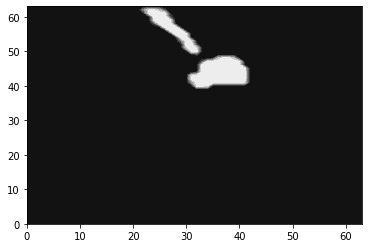

In [75]:
plt.contourf(label_predict[2,2,:,:,0])
plt.gray()

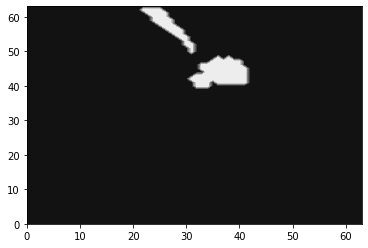

In [76]:
plt.contourf(label_train[2,2,:,:,0])

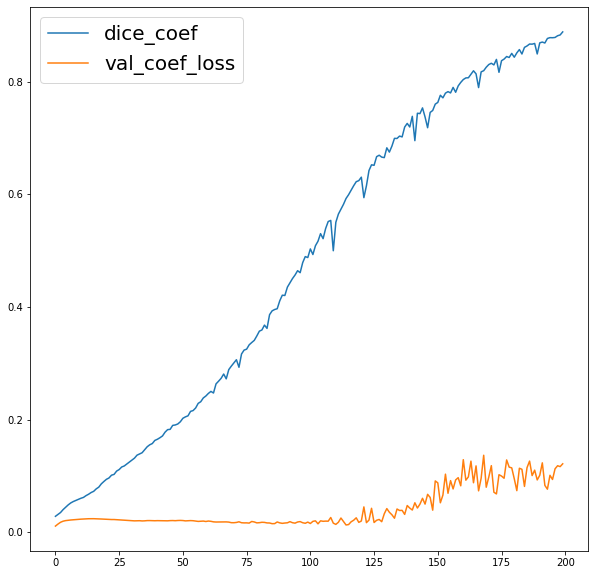

In [72]:

plt.figure(figsize=[10,10])
plt.plot(np.abs(hist.history['dice_coef']),label='dice_coef')
plt.plot(np.abs(hist.history['val_dice_coef']),label='val_coef_loss')
plt.legend(fontsize=20)


plt.savefig('/storage/fig.png')

In [77]:
label_train.shape

(20, 8, 64, 64, 1)